# LayerCAM-Guided Drone Forensics Pipeline (The Searchlight Protocol)

**Objective:** Detect hidden information (people, objects) in high-resolution drone imagery using a coarse-to-fine guided approach.

**Pipeline Stages:**
1. **Guide (LayerCAM):** Use ResNet50's DEEPER layers (Layer 3 + Layer 4) to detect semantic anomalies/objects in the FULL resolution image. This acts as a 'Searchlight'. Uses **class-agnostic max activation** for general detection.
2. **Slicer (Intelligent Cropping):** Extract Regions of Interest (RoIs) based on the heatmap blobs, applying **20-30% context padding**.
3. **Detector (YOLO):** Run high-precision object detection (**YOLOv8-Medium**) only on the high-res crops. Prioritizes **Precision**.
4. **Fusion:** Merge detections back onto the original map.


---
## Imports and Device Configuration

Import all necessary libraries and configure the computing device (CPU/GPU).


In [1]:
##import google.colab as gc
##gc.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
##import os
##os.chdir('/content/drive/MyDrive/new_drone')

In [ ]:
#!pip install -r requirements.txt

In [4]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from ultralytics import YOLO
import os
from torch.cuda.amp import autocast
from torchvision.ops import nms

from Detector import YOLODetector
from ImageLoader import DroneImageLoader
from LayerCam import LayerCAM, MultiLayerCAM
from Slicer import IntelligentSlicer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda
PyTorch version: 2.9.0+cu126
GPU: Tesla T4
GPU Memory Total: 14.7 GB


---
## Pipeline Configuration

Configure the pipeline hyperparameters including:
- **Padding Factor:** Context padding for crops (30-50%)
- **Heatmap Threshold:** Threshold for blob detection
- **YOLO Confidence:** Detection confidence threshold
- **Min Crop Size:** Minimum size for generated crops
- **Image Enhancement:** Contrast adjustment factor


In [17]:
IMAGE_PATH = r'IMG_4025.JPG'

INCREASE_CONTRAST = 1.8

PADDING_FACTOR = 0.4
HEATMAP_THRESHOLD = 0.4
YOLO_CONFIDENCE = 0.3
MIN_CROP_SIZE = 120

MAX_LAYERCAM_DIM = 4096
USE_MIXED_PRECISION = True

print("Configuration:")
print(f"  IMAGE_PATH: {IMAGE_PATH}")
print(f"  PADDING_FACTOR: {PADDING_FACTOR}")
print(f"  HEATMAP_THRESHOLD: {HEATMAP_THRESHOLD}")
print(f"  YOLO_CONFIDENCE: {YOLO_CONFIDENCE}")
print(f"  MIN_CROP_SIZE: {MIN_CROP_SIZE}")
print(f"  MAX_LAYERCAM_DIM: {MAX_LAYERCAM_DIM}")
print(f"  USE_MIXED_PRECISION: {USE_MIXED_PRECISION}")

Configuration:
  IMAGE_PATH: IMG_4025.JPG
  PADDING_FACTOR: 0.4
  HEATMAP_THRESHOLD: 0.4
  YOLO_CONFIDENCE: 0.3
  MIN_CROP_SIZE: 120
  MAX_LAYERCAM_DIM: 4096
  USE_MIXED_PRECISION: True


---
## STAGE 1: Load and Display Original Image

Load the drone image at full resolution (memory-optimized). The loader handles:
- Full resolution preservation when possible
- Memory-efficient tensor creation
- Automatic device placement


STAGE 1: Loading Image (Memory-Optimized)
GPU Memory before load: 262.8 MB
  Original: (5184, 3452) -> Downsampled for CAM: (4096, 2727) (scale: 0.790)
  Tensor shape: torch.Size([1, 3, 2727, 4096]), Memory: 127.83 MB

Image Path: IMG_4025.JPG
Original Size (WxH): (5184, 3452)
Full-Res Array Shape: (3452, 5184, 3)
CAM Tensor Shape: torch.Size([1, 3, 2727, 4096])
Scale Factor: 0.7901
GPU Memory after load: 391.3 MB


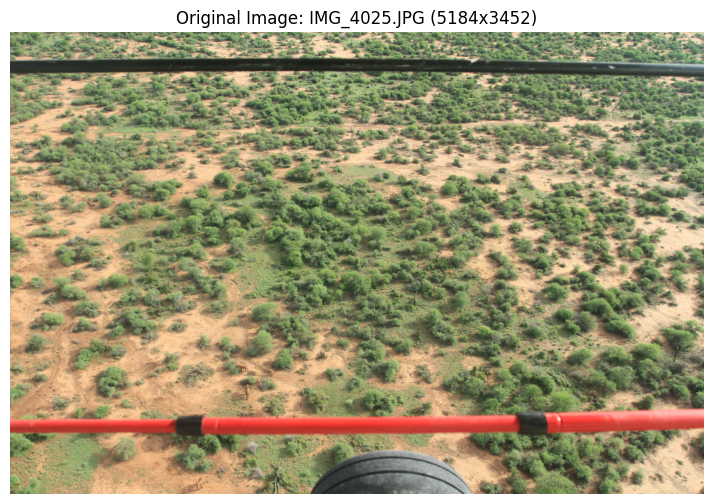

In [18]:
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

print(f"{'='*60}")
print(f"STAGE 1: Loading Image (Memory-Optimized)")
print(f"{'='*60}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory before load: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

loader = DroneImageLoader(max_dim=MAX_LAYERCAM_DIM)
original_np, input_tensor, orig_size, scale_factor = loader.load(IMAGE_PATH)

print(f"\nImage Path: {IMAGE_PATH}")
print(f"Original Size (WxH): {orig_size}")
print(f"Full-Res Array Shape: {original_np.shape}")
print(f"CAM Tensor Shape: {input_tensor.shape}")
print(f"Scale Factor: {scale_factor:.4f}")

if torch.cuda.is_available():
    print(f"GPU Memory after load: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

plt.figure(figsize=(10, 6))
plt.imshow(original_np)
plt.title(f"Original Image: {IMAGE_PATH} ({orig_size[0]}x{orig_size[1]})")
plt.axis('off')
plt.show()

---
## STAGE 2 & 3: LayerCAM Heatmap Generation and Intelligent Slicing

This stage performs:
1. **LayerCAM Heatmap Generation:** Uses ResNet50's geometric/structural layers (Layer 2, 3, 4) to identify regions of interest
2. **Blob Detection:** Identifies significant regions using thresholding and contour detection
3. **Intelligent Cropping:** Extracts crops with context padding while respecting minimum size constraints
4. **NMS (Non-Maximum Suppression):** Reduces overlapping crop regions to prevent redundant detections


STAGE 2: LayerCAM Guide (Geometric Triad: L2+L3+L4)
GPU Memory before model load: 391.3 MB
Loaded ResNet50 (ImageNet pretrained)
GPU Memory after model load: 490.0 MB
Target Layers: layer2[-1] + layer3[-1] + layer4[-1]
Mixed Precision: True

Generating class-agnostic heatmap...
GPU Memory before CAM: 442.6 MB
Applying Weighted Fusion -> L2:0.4 | L3:1.0 | L4:1.0
GPU Memory after CAM: 1054.0 MB
Heatmap Shape: (2727, 4096)
Heatmap Min: 0.0053, Max: 0.9497

GPU Memory after cleanup: 260.8 MB


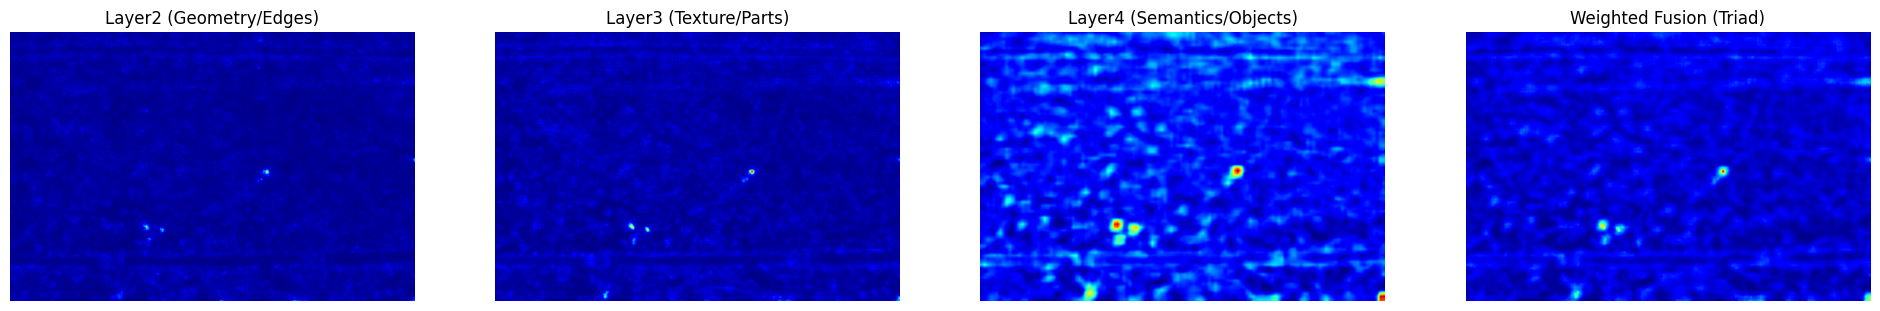


STAGE 3: Intelligent Slicer
  Generated 6 crops (min size: 120px)


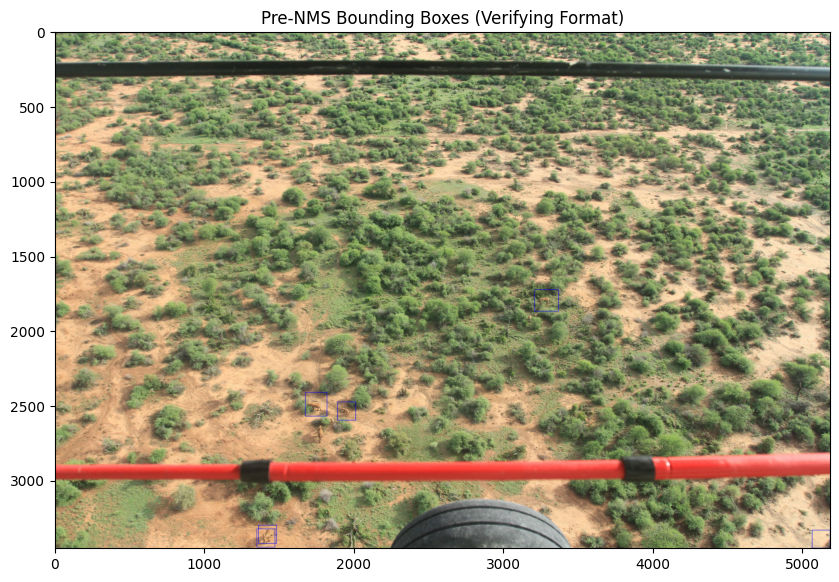


Applying torchvision.ops.nms...
Success! NMS filtered 6 down to 5 crops.


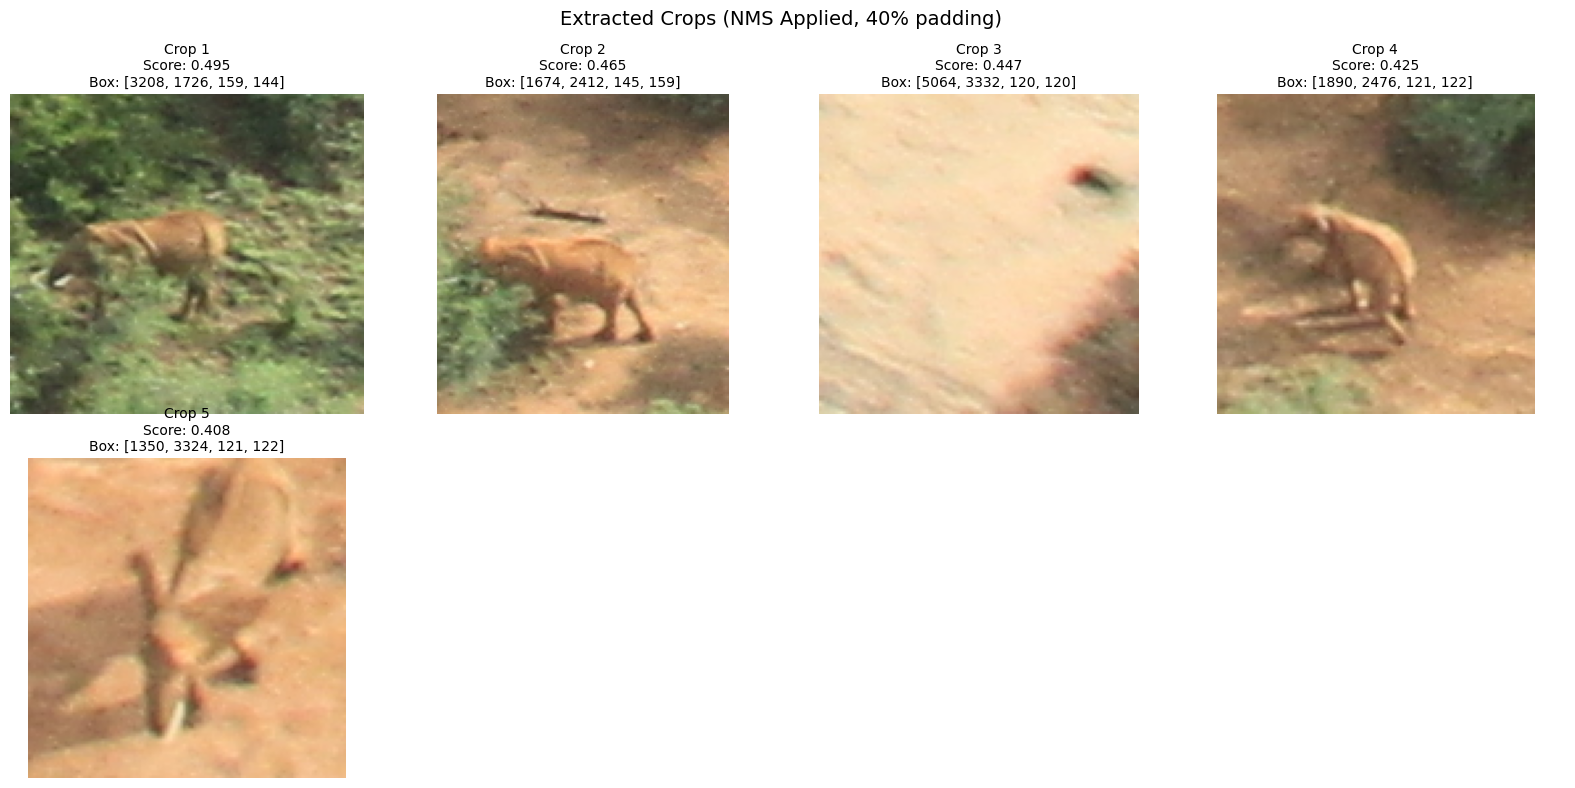

In [19]:
print(f"{'='*60}")
print(f"STAGE 2: LayerCAM Guide (Geometric Triad: L2+L3+L4)")
print(f"{'='*60}")

if torch.cuda.is_available():
    print(f"GPU Memory before model load: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

guide_model = models.resnet50(weights='IMAGENET1K_V1').to(device)
guide_model.eval()
print("Loaded ResNet50 (ImageNet pretrained)")

if torch.cuda.is_available():
    print(f"GPU Memory after model load: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

target_layers = [guide_model.layer2[-1], guide_model.layer3[-1], guide_model.layer4[-1]]
print(f"Target Layers: layer2[-1] + layer3[-1] + layer4[-1]")
print(f"Mixed Precision: {USE_MIXED_PRECISION}")

cam_engine = MultiLayerCAM(guide_model, target_layers)

print("\nGenerating class-agnostic heatmap...")

if torch.cuda.is_available():
    print(f"GPU Memory before CAM: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

_ = cam_engine.generate_combined_cam(input_tensor)

individual_cams = cam_engine.individual_cams.copy()

w2, w3, w4 = 0.4, 1.0, 1.0
print(f"Applying Weighted Fusion -> L2:{w2} | L3:{w3} | L4:{w4}")

heatmap = (individual_cams[0] * w2) + (individual_cams[1] * w3) + (individual_cams[2] * w4)
heatmap = heatmap / (w2 + w3 + w4)

if torch.cuda.is_available():
    print(f"GPU Memory after CAM: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

print(f"Heatmap Shape: {heatmap.shape}")
print(f"Heatmap Min: {heatmap.min():.4f}, Max: {heatmap.max():.4f}")

cam_engine.remove()
del cam_engine, guide_model, input_tensor
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\nGPU Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].set_title("Layer2 (Geometry/Edges)")
axes[0].imshow(individual_cams[0], cmap='jet')
axes[0].axis('off')

axes[1].set_title("Layer3 (Texture/Parts)")
axes[1].imshow(individual_cams[1], cmap='jet')
axes[1].axis('off')

axes[2].set_title("Layer4 (Semantics/Objects)")
axes[2].imshow(individual_cams[2], cmap='jet')
axes[2].axis('off')

axes[3].set_title("Weighted Fusion (Triad)")
axes[3].imshow(heatmap, cmap='jet')
axes[3].axis('off')
plt.show()

del individual_cams

print(f"\n{'='*60}")
print(f"STAGE 3: Intelligent Slicer")
print(f"{'='*60}")

slicer = IntelligentSlicer(padding_factor=PADDING_FACTOR, info_threshold=HEATMAP_THRESHOLD, min_crop_size=MIN_CROP_SIZE)
crops, mask, heatmap_resized = slicer.slice(original_np, heatmap)

debug_img = original_np.copy()

for crop in crops:
    b = crop['bbox']
    x, y, w, h = int(b[0]), int(b[1]), int(b[2]), int(b[3])
    cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(debug_img)
plt.title("Pre-NMS Bounding Boxes (Verifying Format)")
plt.show()

if len(crops) > 0:
    print("\nApplying torchvision.ops.nms...")

    boxes_list = []
    scores_list = []

    for crop in crops:
        x, y, w, h = crop['bbox']
        s = crop['score']

        x1 = float(x)
        y1 = float(y)
        x2 = float(x + w)
        y2 = float(y + h)

        boxes_list.append([x1, y1, x2, y2])
        scores_list.append(float(s))

    boxes_t = torch.tensor(boxes_list, dtype=torch.float32)
    scores_t = torch.tensor(scores_list, dtype=torch.float32)

    iou_threshold = 0.2
    keep_indices = torchvision.ops.nms(boxes_t, scores_t, iou_threshold)

    crops = [crops[i] for i in keep_indices.tolist()]
    print(f"Success! NMS filtered {len(boxes_list)} down to {len(crops)} crops.")

    for i, crop in enumerate(crops):
      crop['id'] = i + 1

if len(crops) > 0:
    n_crops = len(crops)
    cols = min(4, n_crops)
    rows = (n_crops + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    if n_crops == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, crop in enumerate(crops):
        axes[i].imshow(crop['image'])

        box_str = ""
        if 'bbox' in crop:
            b = crop['bbox']
            box_str = f"\nBox: [{int(b[0])}, {int(b[1])}, {int(b[2])}, {int(b[3])}]"

        axes[i].set_title(f"Crop {crop['id']}\nScore: {crop['score']:.3f}{box_str}", fontsize=10)
        axes[i].axis('off')

    for i in range(n_crops, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f"Extracted Crops (NMS Applied, {PADDING_FACTOR*100:.0f}% padding)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No crops extracted. Try lowering HEATMAP_THRESHOLD.")

---
## STAGE 4: YOLO Detection on High-Resolution Crops

Run YOLOv8-Medium object detection on each extracted crop:
- Detects objects within each region of interest
- Applies confidence thresholding
- Maps detections back to original image coordinates


In [20]:
print(f"{'='*60}")
print(f"STAGE 4: YOLO Detection")
print(f"{'='*60}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory before YOLO: {torch.cuda.memory_allocated()/1024**2:.1f} MB")

detector = YOLODetector(model_version='v9',model_variant='c')
print(f"Model: YOLOv9-Complex")
print(f"Confidence Threshold: {YOLO_CONFIDENCE}")

all_detections = []

for crop_data in crops:
    crop = crop_data['image']
    bx, by, bw, bh = crop_data['bbox']
    crop_id = crop_data['id']

    print(f"\nProcessing Crop {crop_id}: Size {crop.shape[1]}x{crop.shape[0]} at ({bx}, {by})")

    with torch.no_grad():
        results = detector.model.predict(
            source=crop,
            conf=YOLO_CONFIDENCE,
            iou=0.6,
            augment=True,
            agnostic_nms=True,
            verbose=False
        )
    n_det = len(results[0].boxes)
    print(f"  Found {n_det} detections")

    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        class_name = results[0].names[cls]

        gx1, gy1 = x1 + bx, y1 + by
        gx2, gy2 = x2 + bx, y2 + by

        all_detections.append({
            'crop_id': crop_id,
            'class': class_name,
            'confidence': conf,
            'global_bbox': [gx1, gy1, gx2, gy2]
        })
        print(f"    - {class_name}: {conf*100:.1f}%")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

STAGE 4: YOLO Detection
GPU Memory before YOLO: 260.8 MB
Model: YOLOv9-Complex
Confidence Threshold: 0.3

Processing Crop 1: Size 159x144 at (3208, 1726)
  Found 1 detections
    - sheep: 41.6%

Processing Crop 2: Size 145x159 at (1674, 2412)
  Found 1 detections
    - sheep: 56.2%

Processing Crop 3: Size 120x120 at (5064, 3332)
  Found 0 detections

Processing Crop 4: Size 121x122 at (1890, 2476)
  Found 0 detections

Processing Crop 5: Size 121x122 at (1350, 3324)
  Found 0 detections


---
## STAGE 5: Results Visualization and Fusion

Visualize the final detection results:
- Draw bounding boxes on original image
- Display detection confidence and class labels
- Show pipeline summary statistics


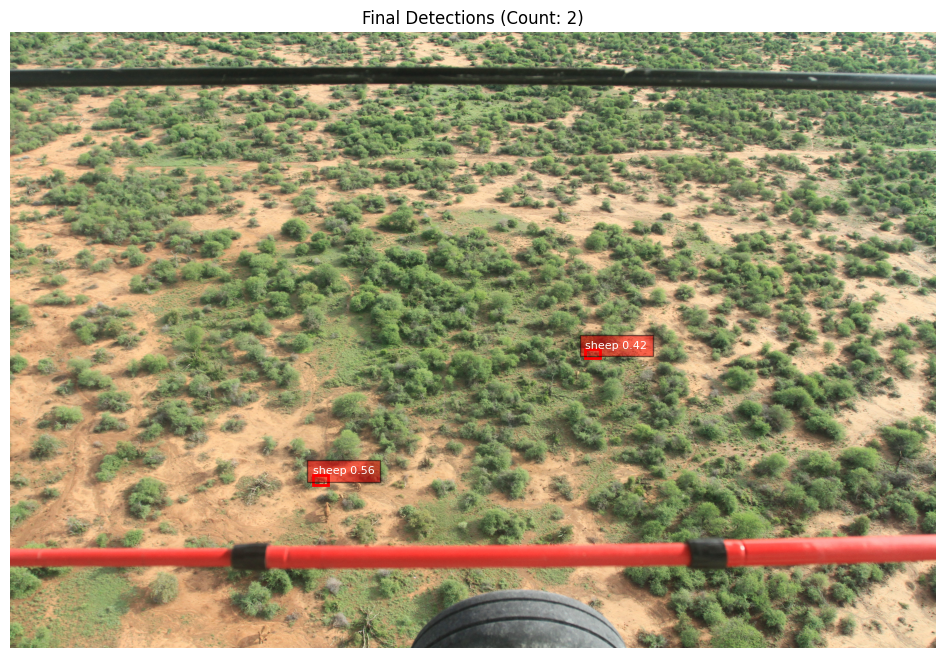


Pipeline Complete!


In [21]:
if len(all_detections) > 0:
    plt.figure(figsize=(12, 8))
    plt.imshow(original_np)
    ax = plt.gca()

    for det in all_detections:
        gx1, gy1, gx2, gy2 = det['global_bbox']
        label = f"{det['class']} {det['confidence']:.2f}"

        rect = plt.Rectangle((gx1, gy1), gx2-gx1, gy2-gy1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(gx1, gy1-5, label, bbox=dict(facecolor='red', alpha=0.5), color='white', fontsize=8)

    plt.title(f"Final Detections (Count: {len(all_detections)})")
    plt.axis('off')
    plt.show()
else:
    print("No detections found.")

print(f"\n{'='*60}")
print("Pipeline Complete!")
print(f"{'='*60}")